In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# import 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
train_dir = os.path.join('../Data/train')
testA_dir = os.path.join('../Data/testA')
categories = ['no_tpo', 'tpo']

In [3]:
for category in categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

no_tpo 9265 images
tpo 10260 images


In [4]:
train = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(19525, 3)

In [5]:
train.head()

,file,category_id,category
0,train/no_tpo/Lambeth_no (295).tif,0,no_tpo
1,train/no_tpo/Lambeth_no (1690).tif,0,no_tpo
2,train/no_tpo/Barnet_no (1941).tif,0,no_tpo
3,train/no_tpo/Barnet_no (130).tif,0,no_tpo
4,train/no_tpo/Lambeth_no (1803).tif,0,no_tpo


In [6]:
testA = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(testA_dir, category)):
        testA.append(['testA/{}/{}'.format(category, file), category_id, category])
testA = pd.DataFrame(testA,columns = ['filepath', 'category_id','category'])
testA.shape

(12796, 3)

In [7]:
testA.head()

,filepath,category_id,category
0,testA/no_tpo/1353.tif,0,no_tpo
1,testA/no_tpo/2152.tif,0,no_tpo
2,testA/no_tpo/488.tif,0,no_tpo
3,testA/no_tpo/5401.tif,0,no_tpo
4,testA/no_tpo/3686.tif,0,no_tpo


In [8]:
#set variables
img_size = 224
new_input=(img_size,img_size,3)
#seed=1
#np.random.seed(seed=seed)

In [9]:
# set trainable layers in ResNet50
resnet=ResNet50(include_top=False, input_shape=new_input, weights='imagenet', pooling='avg')
output=resnet.layers[-1].output
output=keras.layers.Flatten()(output)
resnet=Model(resnet.input, output)
resnet.trainable=True
for layer in resnet.layers[:144]:
    layer.trainable=False
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_...,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activatio...,conv1_relu,False
...,...,...,...
172,<tensorflow.python.keras.layers.normalization_...,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,True
174,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_out,True
175,<tensorflow.python.keras.layers.pooling.Global...,avg_pool,True


In [10]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# create a model with cross validation fold
def Resnet50_with_cv(data, cross_validation,
                     activation, classes, optimizer, loss, metrics, 
                     epochs, batch_size):
    print('Train Model')
    data_generator_valid = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        validation_split=0.2)

    # Data augmentation
    data_generator_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                            horizontal_flip = True,
                                            vertical_flip = True, 
                                            width_shift_range = 0.1,
                                            height_shift_range = 0.1,
                                            brightness_range=[0.8,1.2],
                                            rotation_range=90)

    print("==================================================")
    print('Cross Validation')
    kfold = StratifiedKFold(n_splits = cross_validation, shuffle = True)
    cvscores = []
    iteration = 1
    t = data.category_id
    for train_index, valid_index in kfold.split(np.zeros(len(t)),t):
        print('==================================================')
        print("Iteration=", iteration)
        iteration+=1
        
        train=data.loc[train_index]
        valid=data.loc[valid_index]
        print('==================================================')
        # create model
        print('Create Model')
        layer2=Dense(classes, activation=activation)
        model=Sequential([resnet, layer2])
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        train_generator = data_generator_aug.flow_from_dataframe(dataframe=data,
                                                                 directory= '../Data',
                                                                 x_col='file',
                                                                 y_col='category',
                                                                 #seed=seed,
                                                                 target_size=(img_size, img_size),
                                                                 batch_size=batch_size, 
                                                                 class_mode='categorical')
        valid_generator = data_generator_valid.flow_from_dataframe(dataframe=data,
                                                             directory= '../Data',
                                                             x_col='file',
                                                             y_col='category',
                                                             batch_size=batch_size,
                                                             #seed=seed,
                                                             target_size=(img_size, img_size), 
                                                             class_mode='categorical',
                                                             subset='validation')
        
        earlystop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
        step_train = train_generator.n//train_generator.batch_size
        step_valid = valid_generator.n//valid_generator.batch_size
        # fit the model
        fit_stats = model.fit_generator(train_generator,
                                        steps_per_epoch=step_train,
                                        validation_data=valid_generator,
                                        validation_steps=step_valid,
                                        epochs=epochs,
                                        verbose=1,
                                        callbacks=earlystop)
        scores=model.evaluate_generator(valid_generator, steps=step_valid)
        cvscores.append(scores[-1]*100)
        print("Accuarcy: %.2f%%" % (scores[-1]*100))

        acc=fit_stats.history['accuracy']
        los=fit_stats.history['loss']
        val_acc=fit_stats.history['val_accuracy']
        val_loss=fit_stats.history['val_loss']
        epoch=range(len(acc))

        plt.plot(epoch, acc, 'r', label='Training Accuracy')
        plt.plot(epoch, val_acc, 'b', label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.legend()
        plt.show()

        plt.plot(epoch, los, 'r', label='Training Loss')
        plt.plot(epoch, val_loss, 'b', label='Validation Loss')
        plt.title('Model Loss')
        plt.legend()
        plt.show()
    accuracy = np.mean(cvscores)
    std=np.std(cvscores)
    print('CV_Scores:%.2f%%(+/- %.2f%%)'%(accuracy,std))
    model.save('Aerial_best_cv_model.h5')
    return accuracy, std

Train Model
Cross Validation
Iteration= 1
Create Model
Found 19523 validated image filenames belonging to 2 classes.
Found 3904 validated image filenames belonging to 2 classes.
Epoch 1/25
305/305 [==============================] - 266s 850ms/step - loss: 0.4724 - accuracy: 0.7528 - val_loss: 0.2992 - val_accuracy: 0.8919
Epoch 2/25
305/305 [==============================] - 258s 845ms/step - loss: 0.3528 - accuracy: 0.8114 - val_loss: 0.4739 - val_accuracy: 0.7236
Epoch 3/25
305/305 [==============================] - 258s 846ms/step - loss: 0.3304 - accuracy: 0.8225 - val_loss: 0.3678 - val_accuracy: 0.8076
Epoch 4/25
305/305 [==============================] - 257s 844ms/step - loss: 0.3060 - accuracy: 0.8379 - val_loss: 0.4339 - val_accuracy: 0.7503
Epoch 5/25
305/305 [==============================] - 259s 847ms/step - loss: 0.3015 - accuracy: 0.8427 - val_loss: 0.4967 - val_accuracy: 0.7013
Epoch 6/25
305/305 [==============================] - 258s 847ms/step - loss: 0.2956 - accur

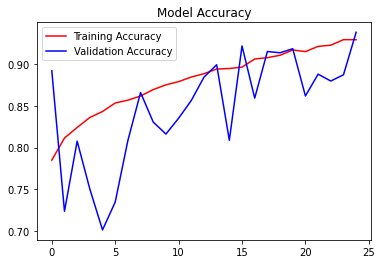

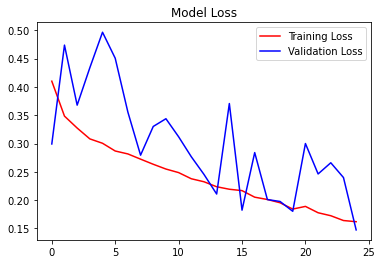

Iteration= 2
Create Model
Found 19523 validated image filenames belonging to 2 classes.
Found 3904 validated image filenames belonging to 2 classes.
Epoch 1/25
305/305 [==============================] - 260s 843ms/step - loss: 0.2996 - accuracy: 0.8493 - val_loss: 0.1277 - val_accuracy: 0.9495
Epoch 2/25
305/305 [==============================] - 257s 842ms/step - loss: 0.1762 - accuracy: 0.9223 - val_loss: 0.0757 - val_accuracy: 0.9749
Epoch 3/25
305/305 [==============================] - 257s 843ms/step - loss: 0.1646 - accuracy: 0.9273 - val_loss: 0.2255 - val_accuracy: 0.8975
Epoch 4/25
305/305 [==============================] - 258s 844ms/step - loss: 0.1503 - accuracy: 0.9354 - val_loss: 0.3964 - val_accuracy: 0.8268
Epoch 5/25
305/305 [==============================] - 258s 844ms/step - loss: 0.1470 - accuracy: 0.9385 - val_loss: 0.1284 - val_accuracy: 0.9506
Epoch 6/25
305/305 [==============================] - 257s 843ms/step - loss: 0.1410 - accuracy: 0.9380 - val_loss: 0.148

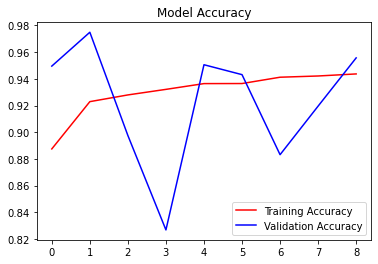

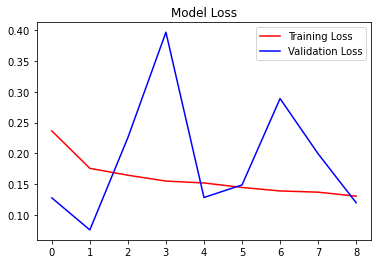

Iteration= 3
Create Model
Found 19523 validated image filenames belonging to 2 classes.
Found 3904 validated image filenames belonging to 2 classes.
Epoch 1/25
305/305 [==============================] - 261s 848ms/step - loss: 0.2611 - accuracy: 0.8741 - val_loss: 0.2435 - val_accuracy: 0.8924
Epoch 2/25
305/305 [==============================] - 258s 846ms/step - loss: 0.1705 - accuracy: 0.9243 - val_loss: 0.3063 - val_accuracy: 0.8591
Epoch 3/25
305/305 [==============================] - 257s 841ms/step - loss: 0.1492 - accuracy: 0.9368 - val_loss: 0.6041 - val_accuracy: 0.7582
Epoch 4/25
305/305 [==============================] - 259s 849ms/step - loss: 0.1482 - accuracy: 0.9362 - val_loss: 0.1217 - val_accuracy: 0.9503
Epoch 5/25
305/305 [==============================] - 258s 847ms/step - loss: 0.1411 - accuracy: 0.9373 - val_loss: 0.1483 - val_accuracy: 0.9429
Epoch 6/25
305/305 [==============================] - 257s 841ms/step - loss: 0.1354 - accuracy: 0.9431 - val_loss: 0.123

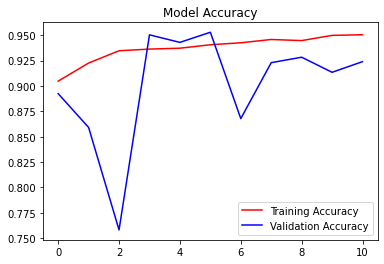

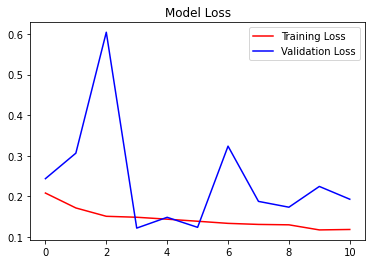

Iteration= 4
Create Model
Found 19523 validated image filenames belonging to 2 classes.
Found 3904 validated image filenames belonging to 2 classes.
Epoch 1/25
305/305 [==============================] - 261s 847ms/step - loss: 0.2367 - accuracy: 0.8934 - val_loss: 0.1032 - val_accuracy: 0.9626
Epoch 2/25
305/305 [==============================] - 258s 846ms/step - loss: 0.1495 - accuracy: 0.9358 - val_loss: 0.1311 - val_accuracy: 0.9495
Epoch 3/25
305/305 [==============================] - 258s 846ms/step - loss: 0.1427 - accuracy: 0.9381 - val_loss: 0.1314 - val_accuracy: 0.9508
Epoch 4/25
305/305 [==============================] - 257s 842ms/step - loss: 0.1324 - accuracy: 0.9447 - val_loss: 0.2166 - val_accuracy: 0.9060
Epoch 5/25
305/305 [==============================] - 258s 845ms/step - loss: 0.1278 - accuracy: 0.9470 - val_loss: 0.1348 - val_accuracy: 0.9511
Epoch 6/25
305/305 [==============================] - 257s 844ms/step - loss: 0.1234 - accuracy: 0.9478 - val_loss: 0.196

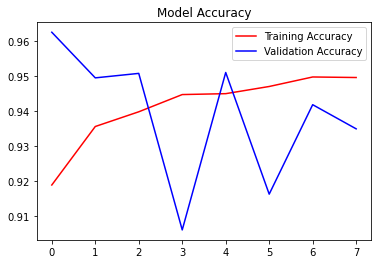

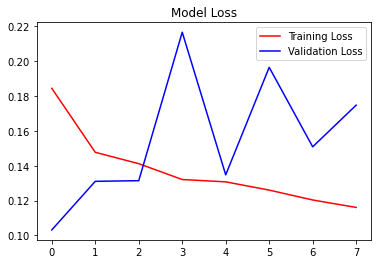

Iteration= 5
Create Model
Found 19523 validated image filenames belonging to 2 classes.
Found 3904 validated image filenames belonging to 2 classes.
Epoch 1/25
305/305 [==============================] - 261s 848ms/step - loss: 0.2250 - accuracy: 0.8972 - val_loss: 0.1099 - val_accuracy: 0.9585
Epoch 2/25
305/305 [==============================] - 257s 844ms/step - loss: 0.1400 - accuracy: 0.9411 - val_loss: 0.3868 - val_accuracy: 0.8371
Epoch 3/25
305/305 [==============================] - 257s 842ms/step - loss: 0.1498 - accuracy: 0.9383 - val_loss: 0.2326 - val_accuracy: 0.9001
Epoch 4/25
305/305 [==============================] - 258s 847ms/step - loss: 0.1251 - accuracy: 0.9466 - val_loss: 0.2449 - val_accuracy: 0.9239
Epoch 5/25
305/305 [==============================] - 257s 843ms/step - loss: 0.1223 - accuracy: 0.9452 - val_loss: 0.1770 - val_accuracy: 0.9303
Epoch 6/25
305/305 [==============================] - 257s 843ms/step - loss: 0.1230 - accuracy: 0.9461 - val_loss: 0.339

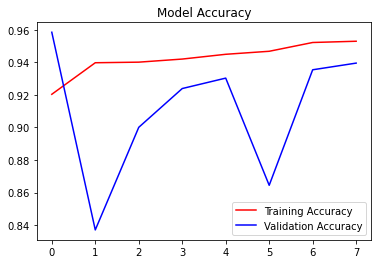

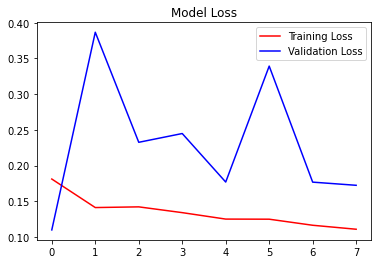

CV_Scores:95.69%(+/- 1.23%)


(95.68647503852844, 1.2322376836534419)

In [12]:
Resnet50_with_cv(train, cross_validation=5,
                 activation='softmax', classes=2, optimizer='sgd', 
                 loss='categorical_crossentropy',metrics=['accuracy'], 
                 epochs=25, batch_size=64)

In [13]:
model_test = load_model("Aerial_best_cv_model.h5")

In [14]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testA_generator = data_generator.flow_from_dataframe(dataframe=testA,
                                                    directory='../Data',
                                                    x_col="filepath",
                                                    y_col='category',
                                                    class_mode='categorical',
                                                    batch_size=1,
                                                    target_size=(img_size, img_size))

Found 12796 validated image filenames belonging to 2 classes.


In [15]:
# test trained model
step_test=testA_generator.n//testA_generator.batch_size
test_score=model_test.evaluate_generator(testA_generator, steps=step_test)

In [16]:
print(test_score)

[1.7647980451583862, 0.5229759216308594]
